# <center> Text Classification with womens-ecommerce-clothing-reviews data set</center>

I am very glad to welcome you all to my notebook, In this notebook I'm going to work on a text classification problem. The problem is described as **'Given Review about clothing on E-commerce predict whether the custoomer will recommed it to her friends or not'...**<br/><br/>
I need to mention one thing I'm new to Machine Learning with text and I have used very easy and effective approaches to solve this problem. I have done some data analysis, data visualizations then finally build both machine learning and deep learning models.
It's time to jump on the process but before that I will mention the Workflow:<br/><br/>
**1)Loading the data<br/>
2)Handling Missing Values<br/>
3)Cleaning the data<br/>
4)Data Analysis and Visualization<br/>
5)Handling MultiColinearity<br/>
6)Tokenisation+stemming+corpus creation<br/>
7)Buidling ML model using Bag of words<br/>
8)Building ML model using Tf-Idf Vectoriztion<br/>
9)Deep Learning Model with Embeddings<br/>
10)Checking the model with new example**

In [2]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Loading the Data

In [3]:
data = pd.read_csv('/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv',index_col =[0])

In [4]:
data.head(10)

In [5]:
data.shape

# Checking For Missing Values and Handling it

In [6]:
data.isnull().sum()

In [7]:
data.isnull().sum()/len(data)*100

In [8]:
data.info()

In [9]:
data.drop(labels =['Clothing ID','Title'],axis = 1,inplace = True) #Dropping unwanted columns

In [10]:
data[data['Review Text'].isnull()]

In [11]:
np.unique(data["Recommended IND"].values)

In [12]:
data['Review Text'].isnull().values.sum()

In [13]:
data = data[~data['Review Text'].isnull()]  #Dropping columns which don't have any review

In [14]:
data.shape

# Data Analysis and Visualization

In [15]:
import plotly.express as px

In [16]:
px.histogram(data, x = 'Age')

In [17]:
px.histogram(data, x = data['Rating'])

In [18]:
px.histogram(data, x = data['Class Name'])

In [19]:
px.scatter(data, x="Age", y="Positive Feedback Count", facet_row="Recommended IND", facet_col="Rating",trendline="ols",category_orders={"Rating": [1,2,3,4,5],'Recommended IND':[0,1]})

In [20]:
px.violin(data, x="Age", y="Department Name", orientation="h", color="Recommended IND")

In [21]:
px.box(data, x="Age", y="Division Name", orientation="h",color = 'Recommended IND')

# Cleaning the Text Data

In [22]:
data['Review Text'].str.extractall("(&amp)")

In [23]:
err1 = data['Review Text'].str.extractall("(&amp)")
err2 = data['Review Text'].str.extractall("(\xa0)")

In [24]:
print('with &amp',len(err1[~err1.isna()]))
print('with (\xa0)',len(err2[~err2.isna()]))

In [25]:
data['Review Text'] = data['Review Text'].str.replace('(&amp)','')
data['Review Text'] = data['Review Text'].str.replace('(\xa0)','')

In [26]:
err1 = data['Review Text'].str.extractall("(&amp)")
print('with &amp',len(err1[~err1.isna()]))
err2 = data['Review Text'].str.extractall("(\xa0)")
print('with (\xa0)',len(err2[~err2.isna()]))

In [27]:
!pip install TextBlob
from textblob import *

In [28]:
data['polarity'] = data['Review Text'].map(lambda text: TextBlob(text).sentiment.polarity)

In [29]:
data['polarity']

In [30]:
px.histogram(data, x = 'polarity')

In [31]:
px.box(data, y="polarity", x="Department Name", orientation="v",color = 'Recommended IND')

In [32]:
data['review_len'] = data['Review Text'].astype(str).apply(len)

In [33]:
px.histogram(data, x = 'review_len')

In [34]:
data['token_count'] = data['Review Text'].apply(lambda x: len(str(x).split()))

In [35]:
px.histogram(data, x = 'token_count')

In [36]:
data[["Review Text", "review_len", "token_count"]].head(2)

# Reviews with Positive Polarity

In [37]:
sam = data.loc[data.polarity == 1,['Review Text']].sample(3).values

In [38]:
for i in sam:
    print(i[0] + "\n\n")

# Reviews with Neutral Polarity

In [39]:
sam = data.loc[data.polarity == 0.5,['Review Text']].sample(3).values

In [40]:
for i in sam:
    print(i[0] + "\n\n")

# Reviews with Negative Polarity

In [41]:
sam = data.loc[data.polarity < 0,['Review Text']].sample(3).values

In [42]:
for i in sam:
    print(i[0] + "\n\n")

In [43]:
negative = (len(data.loc[data.polarity <0,['Review Text']].values)/len(data))*100
positive = (len(data.loc[data.polarity >0.5,['Review Text']].values)/len(data))*100
neutral  = len(data.loc[data.polarity >0 ,['Review Text']].values) - len(data.loc[data.polarity >0.5 ,['Review Text']].values)
neutral = neutral/len(data)*100

# Pie-Chart about Polarity

In [44]:
from matplotlib import pyplot as plt 
plt.figure(figsize =(10, 7)) 
plt.pie([positive,negative,neutral], labels = ['Positive','Negative','Neutral']) 

In [45]:
from sklearn.feature_extraction.text import CountVectorizer

In [46]:
def top_n_ngram(corpus,n = None,ngram = 1):
    vec = CountVectorizer(stop_words = 'english',ngram_range=(ngram,ngram)).fit(corpus)
    bag_of_words = vec.transform(corpus) #Have the count of  all the words for each review
    sum_words = bag_of_words.sum(axis =0) #Calculates the count of all the word in the whole review
    words_freq = [(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq,key = lambda x:x[1],reverse = True)
    return words_freq[:n]

# Visualizing Top 20 Unigrams

In [47]:
common_words = top_n_ngram(data['Review Text'], 20,1)
df = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
plt.figure(figsize =(10,5))
df.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
kind='bar', title='Top 20 unigrams in review after removing stop words')

# Visualizing Top 20 Bigrams

In [48]:
common_words = top_n_ngram(data['Review Text'], 20,2)
df = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
plt.figure(figsize =(10,5))
df.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
kind='bar', title='Top 20 bigrams in review after removing stop words')

# Visualizing Top 20 Trigrams

In [49]:
common_words = top_n_ngram(data['Review Text'], 20,3)
df = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
plt.figure(figsize =(10,5))
df.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
kind='bar', title='Top 20 trigrams in review after removing stop words')

# Visualizing Top 20 Part-of-Speech

In [50]:
blob= TextBlob(str(data['Review Text']))
pos = pd.DataFrame(blob.tags,columns =['word','pos'])
pos1 = pos.pos.value_counts()[:20]
plt.figure(figsize = (10,5))
pos1.plot(kind='bar',title ='Top 20 Part-of-speech taggings')

In [51]:
y = data['Recommended IND']

In [52]:
X = data.drop(columns = 'Recommended IND')

# Correlation HeatMap

In [53]:
import seaborn as sns
sns.heatmap(X.corr(),annot =True)

# Handling Multi-Colinearity

In [54]:
set1 =set()
cor = X.corr()
for i in cor.columns:
    for j in cor.columns:
        if cor[i][j]>0.8 and i!=j:
            set1.add(i)
print(set1)

In [55]:
X = X.drop(labels = ['token_count'],axis = 1)

In [56]:
X.corr()

In [57]:
class1 =[]
for i in X.polarity:
    if float(i)>=0.0:
        class1.append(1)
    elif float(i)<0.0:
        class1.append(0)
X['sentiment'] = class1

In [58]:
np.unique(class1)

In [59]:
X

# Statistical Description of Data

In [60]:
X.groupby(X['sentiment']).describe().T

# Model Building

In [61]:
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [62]:
corpus =[]

In [63]:
X.index = np.arange(len(X))

In [64]:
X.head(10)

# RE + Tokenizing + Stemming + Corpus Creation

In [106]:
for i in range(len(X)):
    review = re.sub('[^a-zA-z]',' ',X['Review Text'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review =[ps.stem(i) for i in review if not i in set(stopwords.words('english'))]
    review =' '.join(review)
    corpus.append(review)

# Bag of Words Technique

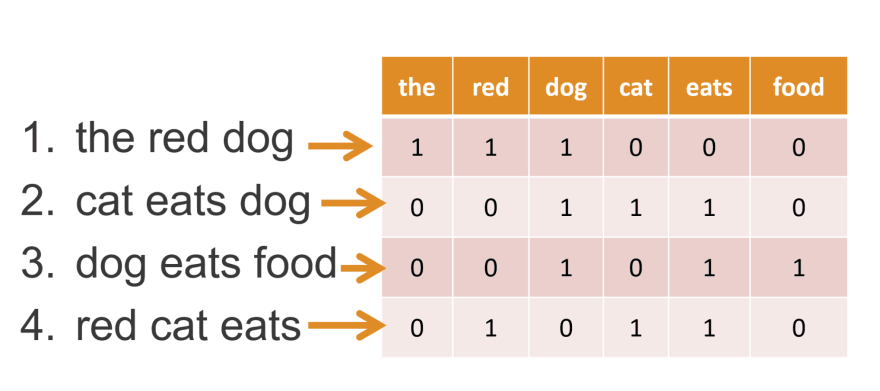

In [66]:
corpus[0]

In [108]:
from sklearn.feature_extraction.text import CountVectorizer as CV
cv  = CV(max_features = 3000,ngram_range=(1,1))
X_cv = cv.fit_transform(corpus).toarray()
# y = y.values

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_cv, y, test_size = 0.20, random_state = 0)

In [69]:
from sklearn.naive_bayes import BernoulliNB
classifier = BernoulliNB()
classifier.fit(X_train, y_train)

In [112]:
corpus[:5]

In [111]:
tst = cv.transform(corpus[:5])
classifier.predict(tst)

In [103]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)

In [71]:
acc

# Term Frequency- Inverse Document Frequency Technique

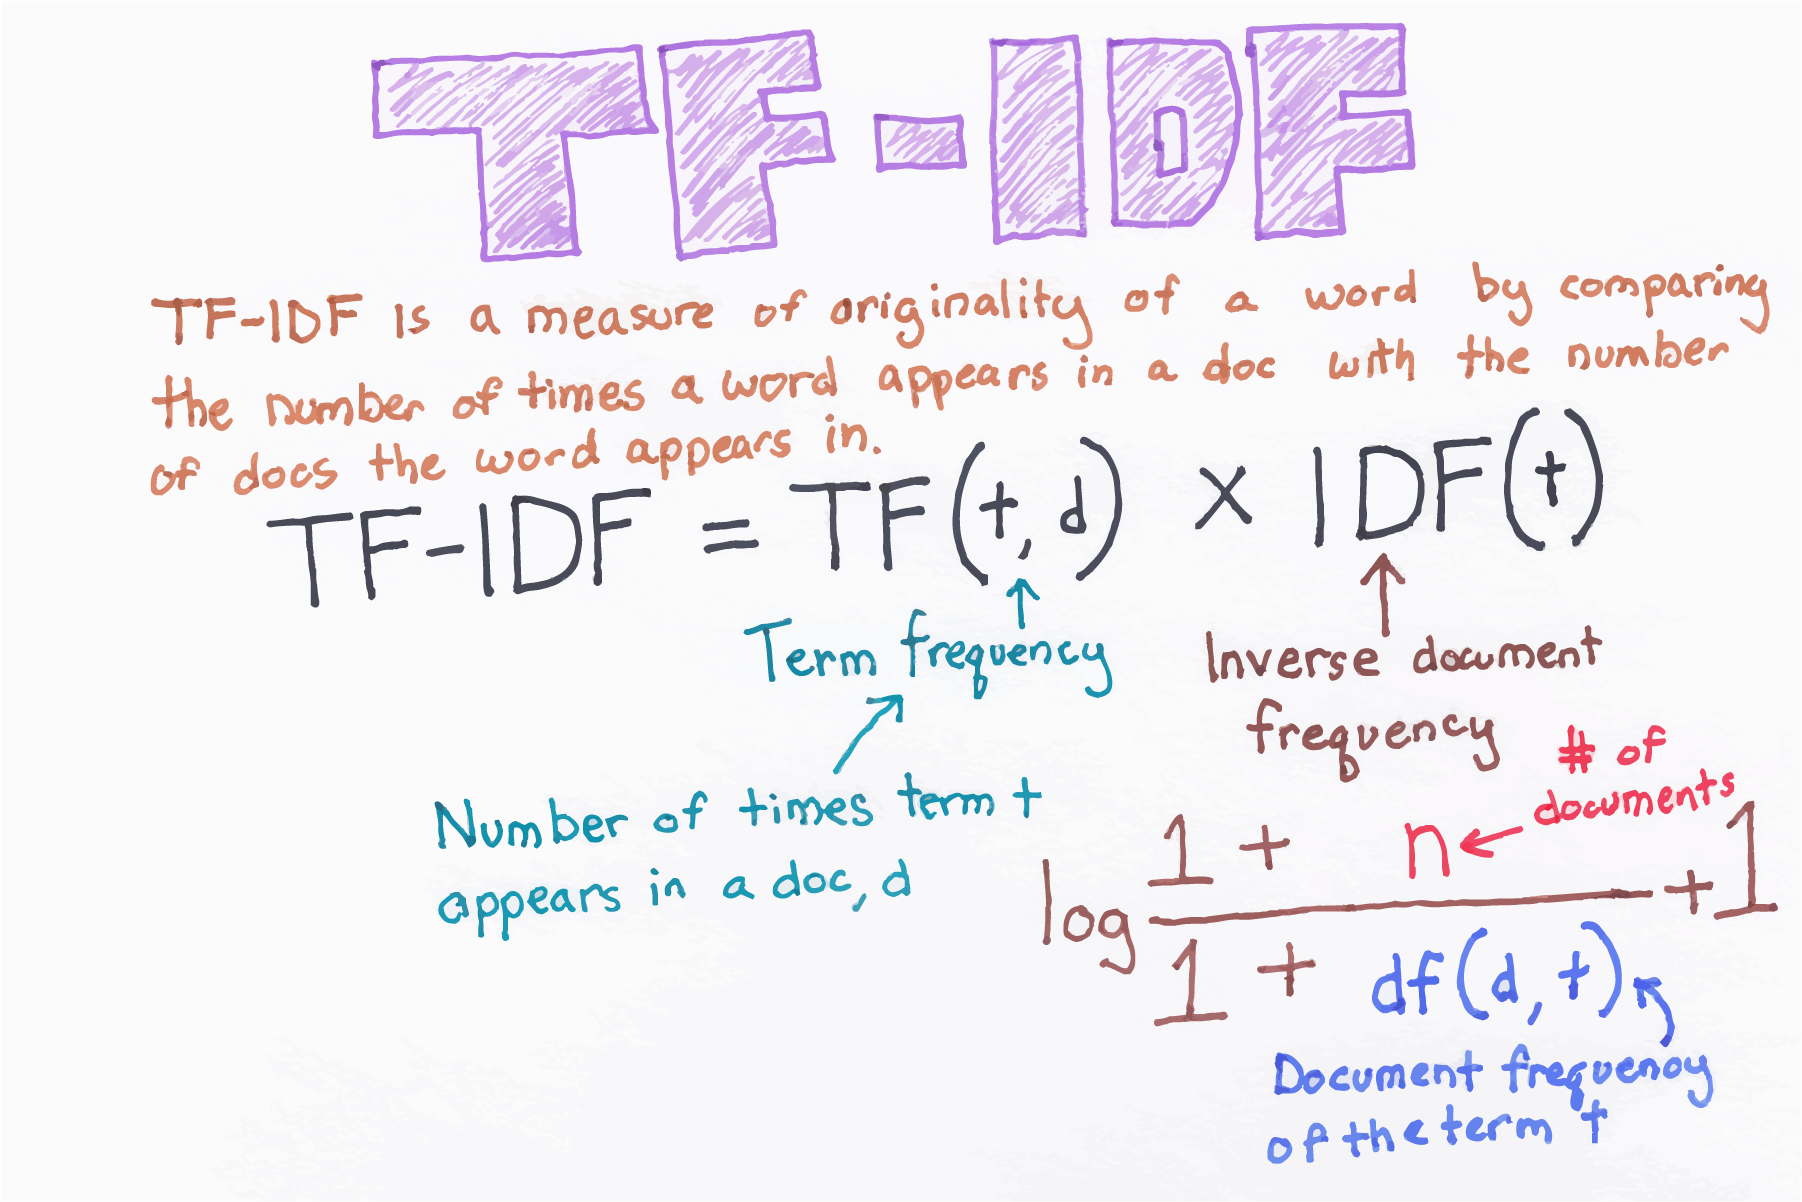

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer as TV
tv  = TV(ngram_range =(1,1),max_features = 3000)
X_tv = tv.fit_transform(corpus).toarray()

In [73]:
X_tv.shape

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_tv, y, test_size = 0.20, random_state = 0)
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

In [75]:
y_pred = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)

In [76]:
acc

# Deep Learning Model

In [77]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [78]:
tf.__version__

In [79]:
corpus[:5]

In [80]:
tokenizer = Tokenizer(num_words = 3000)
tokenizer.fit_on_texts(corpus)

In [81]:
sequences = tokenizer.texts_to_sequences(corpus)
padded = pad_sequences(sequences, padding='post')

In [82]:
y.shape, padded.shape

In [83]:
X_train, X_test, y_train, y_test = train_test_split(padded, y, test_size = 0.20, random_state = 0)

In [84]:
word_index = tokenizer.word_index
count = 0
for i,j in word_index.items():
    if count == 11:
        break
    print(i,j)
    count = count+1

In [85]:
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(3000, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

In [86]:
num_epochs = 50
batch_size = 64
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=2,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [87]:
print("Fit model on training data")
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    callbacks=callback,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_test, y_test),
)

In [88]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X_test[:5])
print("predictions shape:", predictions.shape)

In [89]:
predictions

In [90]:
y_test[:5]

In [91]:
X_test[:5]

In [92]:
model.evaluate(X_test[:5], y_test[:5], batch_size=5)

CHECKING NEW EXAMPLE

In [93]:
sample_string = "I Will tell my friends for sure"
sample = tokenizer.texts_to_sequences(sample_string)
padded_sample = pad_sequences(sample, padding='post')

In [94]:
padded_sample.T

In [95]:
model.predict(padded_sample.T)

**That's all for this notebook....See you soon!!!**<br/>
*If you like my work upvote it!!!!!*